In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter



In [2]:
desired_cols = ['osg_fish1_x','osg_fish1_y', 'osg_fish1_z','framenumber','real_fish_x', 'real_fish_y', 'real_fish_z','velocity', 'Stim_Flag', 'Stim_Flag_dir', 'exp_uuid', 'frame_diff', 'steps',
       'xs_rf', 'ys_rf', 'zs_rf']
df = pd.read_csv(r'C:\PhD\experiments\fish_experiments\FishSizeKinematics\data\0712vr3_1_112_a28.csv_processed.csv', usecols=desired_cols)


C:\Users\kkumari\AppData\Local\Temp\ipykernel_36448\1761184208.py:3: DtypeWarning: Columns (4,5,6,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\PhD\experiments\fish_experiments\FishSizeKinematics\data\0712vr3_1_112_a28.csv_processed.csv', usecols=desired_cols)


In [3]:
def calc_proximity(df):

    print(f'lenght of df before dropna: {len(df)}')

    df= df.dropna()

    x_rf, y_rf, z_rf = pd.to_numeric(df['xs_rf']), pd.to_numeric(df['ys_rf']), pd.to_numeric(df['zs_rf'])
    x_vf, y_vf, z_vf = pd.to_numeric(df['osg_fish1_x']), pd.to_numeric(df['osg_fish1_y']), pd.to_numeric(df['osg_fish1_z'])

    
# # Correct way to assign values using .loc to avoid SettingWithCopyWarning
#     df.loc[:, ['x_rf', 'y_rf', 'z_rf', 'x_vf', 'y_vf', 'z_vf']] = x_rf, y_rf, z_rf, x_vf, y_vf, z_vf
    
    df.loc[:, 'x_rf'] = x_rf
    df.loc[:, 'y_rf'] = y_rf
    df.loc[:, 'z_rf'] = z_rf
    df.loc[:, 'x_vf'] = x_vf
    df.loc[:, 'y_vf'] = y_vf
    df.loc[:, 'z_vf'] = z_vf
  
    # df = df[(df['z_rf'] >= -0.06) & (df['z_rf'] <= -0.04)]
    df['euclidean_distance'] = np.sqrt((x_rf-x_vf)**2 + (y_rf-y_vf)**2 + (z_rf-z_vf)**2)

    print(f'lenght of df after dropna: {len(df)}')

    return df

In [4]:
def coordinate_transition(df):

    heading_vf = df['heading_vf']
    x_rf, y_rf = df['x_rf'], df['y_rf']
    x_vf, y_vf = df['x_vf'], df['y_vf']

    # Calculate the relative position of the real fish to the virtual fish
    x_in, y_in = x_rf - x_vf, y_rf - y_vf

    x_o = x_in*np.cos(heading_vf) + y_in*np.sin(heading_vf)
    y_o = -x_in*np.sin(heading_vf) + y_in*np.cos(heading_vf)

    df.loc[:, 'x_o'] = x_o
    df.loc[:, 'y_o'] = y_o

    print(f'length of transitioned df: {len(df)}')

    return df

In [5]:
def calc_relative_heading(df):
    df = df.dropna()
    df = calc_proximity(df)
    dt = 0.01

    df['dxs_rf'] = df['x_rf'].diff()
    df['dys_rf'] = df['y_rf'].diff()
    df['dxs_vf'] = df['x_vf'].diff()
    df['dys_vf'] = df['y_vf'].diff()

    df['heading_rf']= np.arctan2(df['dys_rf'], df['dxs_rf'])
    df['heading_vf']= np.arctan2(df['dys_vf'], df['dxs_vf'])

    df['relative_heading'] = df['heading_rf'] - df['heading_vf']
    relative_heading = df['relative_heading']

    unwrapped_relative_heading = np.unwrap(relative_heading)
    print(f'unwrapped relative heading: {unwrapped_relative_heading}')

    wrapped_relative_heading = (unwrapped_relative_heading + np.pi) % (2 * np.pi) - np.pi

    print(f'wrapped relative heading: {wrapped_relative_heading}')

    threshold_radians = np.radians(30)

    relative_heading_follow = np.where(np.abs(relative_heading) <= threshold_radians, 1, 0)

    df['relative_heading_follow'] = relative_heading_follow

    print(f'proportion of time fish follows: {np.mean(relative_heading_follow)}')
    
    # Assuming df is your DataFrame and relative_heading_follow is an array or Series of the same length
    filtered_df = df[relative_heading_follow == 1]

    print(f'length of filtered_df: {len(filtered_df)}')

    df = coordinate_transition(filtered_df)

    rf_behind_vf = np.where(df['x_o'] < 0, 1, 0)
    rf_behind_vf = np.where(df['y_o'] < 0, 1, 0)

    df['rf_behind_vf'] = rf_behind_vf

    print(f'rf_behind_vf: {rf_behind_vf}')
    print(f'proportion of time fish is behind: {np.mean(rf_behind_vf)}')

    final_df = df[df['rf_behind_vf'] == 1]

    print('length of final_df: ', len(final_df))

    return final_df

In [6]:
df = calc_relative_heading(df)


lenght of df before dropna: 654945
lenght of df after dropna: 654945
unwrapped relative heading: [nan nan nan ... nan nan nan]
wrapped relative heading: [nan nan nan ... nan nan nan]
proportion of time fish follows: 0.2362977043873913
length of filtered_df: 154762
length of transitioned df: 154762
rf_behind_vf: [0 0 0 ... 0 0 0]
proportion of time fish is behind: 0.3879699150954369
length of final_df:  60043


C:\Users\kkumari\AppData\Local\Temp\ipykernel_36448\733572900.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'x_o'] = x_o
C:\Users\kkumari\AppData\Local\Temp\ipykernel_36448\733572900.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'y_o'] = y_o


In [7]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

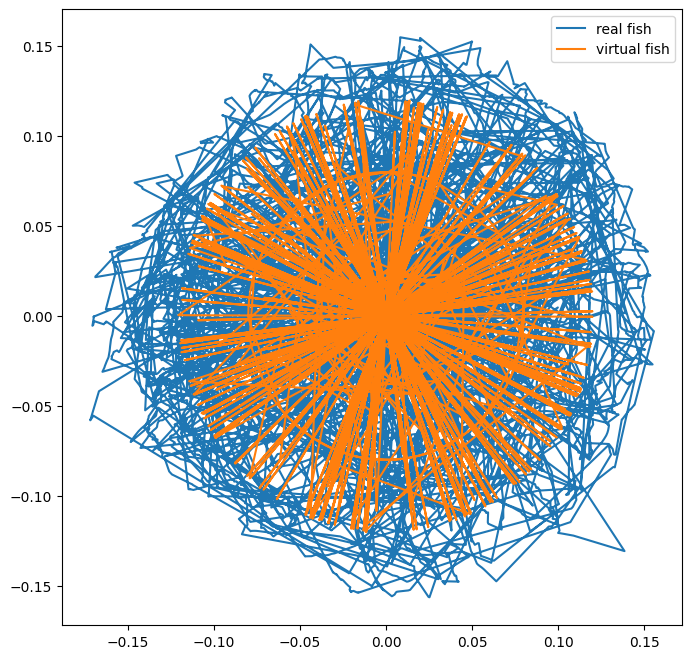

In [9]:
fig = plt.figure(figsize=(8,8))
plt.plot(df['x_rf'], df['y_rf'], label='real fish')
plt.plot(df['x_vf'], df['y_vf'], label='virtual fish')
plt.legend()
plt.show()



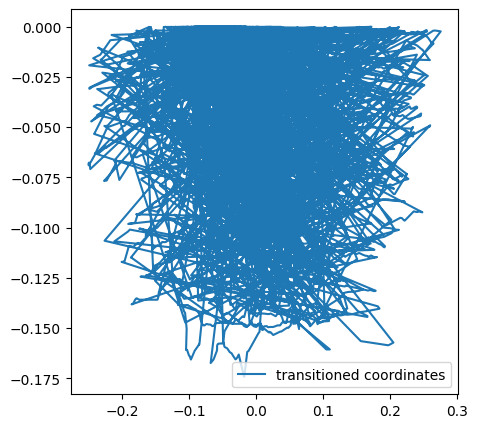

In [10]:
# plot transitioned coordinates

fig = plt.figure(figsize=(5,5))
plt.plot(df['x_o'], df['y_o'], label='transitioned coordinates')
plt.legend()
plt.show()


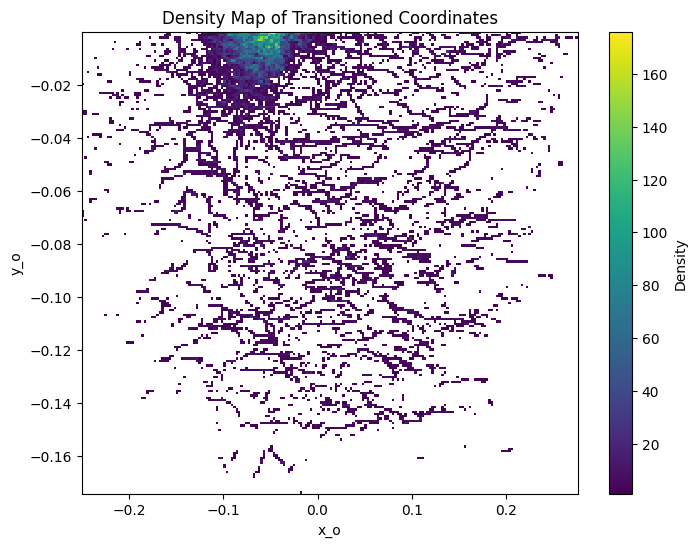

In [20]:
fig = plt.figure(figsize=(8, 6))
plt.hist2d(df['x_o'], df['y_o'], bins=200, cmap='viridis', cmin=1)
plt.colorbar(label='Density')
plt.xlabel('x_o')
plt.ylabel('y_o')
plt.title('Density Map of Transitioned Coordinates')
plt.show()

In [12]:
r_rf, theta_rf = cartesian_to_polar(df['x_rf'], df['y_rf'])
r_vf, theta_vf = cartesian_to_polar(df['x_vf'], df['y_vf'])

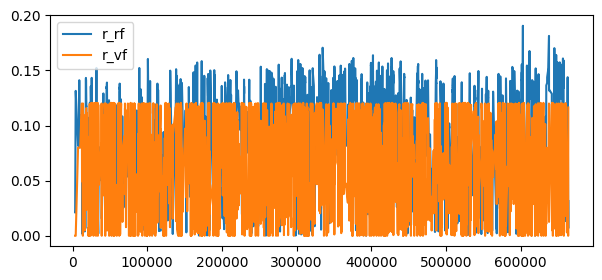

In [17]:
# summarise r_rf and r_vf

fig = plt.figure(figsize=(7,3))
plt.plot(r_rf, label='r_rf')
plt.plot(r_vf, label='r_vf')
plt.legend()
plt.show()


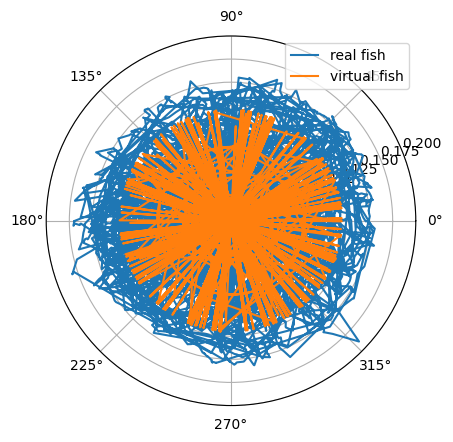

In [14]:
# Create a polar subplot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_rf, r_rf, label='real fish')
ax.plot(theta_vf, r_vf, label='virtual fish')
ax.legend()
plt.show()
